In [ ]:
!nvidia-smi

Thu Aug  5 09:00:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Download dataset and import Package

**Package Install**

In [ ]:
workspace_dir = '.'
!pip install -q qqdm

**Download dataset**

In [ ]:
!gdown --id 1IGrTr308mGAaCKotpkkm8wTKlWs9Jq-p --output "{workspace_dir}/crypko_data.zip"

Downloading...
From: https://drive.google.com/uc?id=1IGrTr308mGAaCKotpkkm8wTKlWs9Jq-p
To: /content/crypko_data.zip
452MB [00:02, 172MB/s]


**unzip the download file**

In [ ]:
!unzip -q "{workspace_dir}/crypko_data.zip" -d "{workspace_dir}/"

**Random Seed**

In [ ]:
import random
import torch
import numpy as np

def same_seeds(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

same_seeds(2021)

**Import Package**

In [ ]:
import os
import glob

import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from qqdm.notebook import qqdm

# Dataset


In [ ]:
class CrypkoDataset(Dataset):
  def __init__(self, fnames, transform):
    self.transform = transform
    self.fnames = fnames
    self.num_samples = len(self.fnames)
  def __getitem__(self, idx):
    fname = self.fnames[idx]
    #load the image
    img = torchvision.io.read_image(fname)
    #resize and normalize the images using torchvision
    img = self.transform(img)
    return img
  def __len__(self):
    return self.num_samples

def get_dataset(root):
  fnames = glob.glob(os.path.join(root, '*'))

  compose = [
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5)),
  ]
  transform = transforms.Compose(compose)
  dataset = CrypkoDataset(fnames, transform)
  return dataset

**Show some image**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


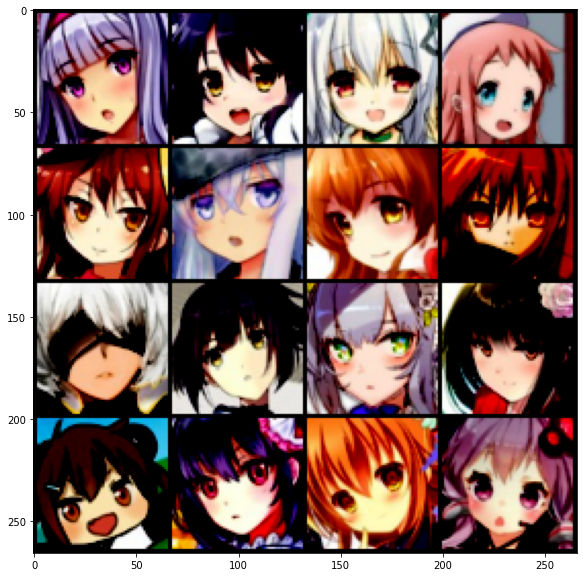

In [ ]:
dataset = get_dataset(os.path.join(workspace_dir, 'faces'))

images = [dataset[i] for i in range(16)]
grid_img = torchvision.utils.make_grid(images, nrow = 4)
plt.figure(figsize = (10, 10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

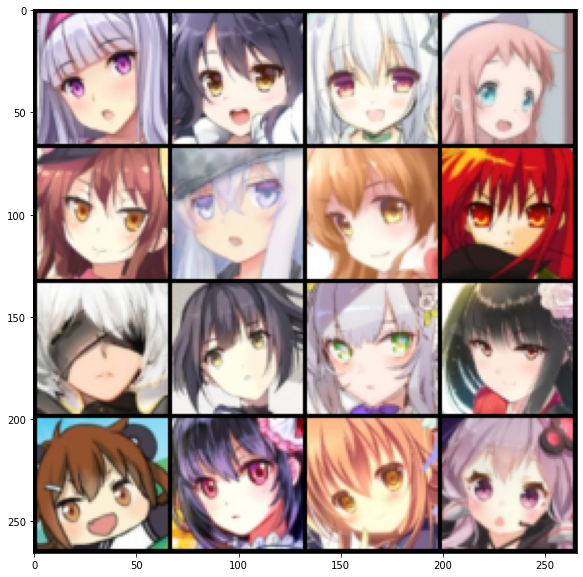

In [ ]:
images = [(dataset[i] + 1)/2 for i in range(16)]
grid_img = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

# Model

**Generator**

In [ ]:
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    m.weight.data.normal_(0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    m.weight.data.normal_(1.0 ,0.02)
    m.bias.data.fill_(0)

class Generator(nn.Module):
  def __init__(self, in_dim, dim = 64):
    super(Generator, self).__init__()
    def dconv_bn_relu(in_dim, out_dim):
      return nn.Sequential(
          nn.ConvTranspose2d(in_dim, out_dim, 5, 2, padding = 2, output_padding = 1, bias = False),
          nn.BatchNorm2d(out_dim),
          nn.ReLU()
      )
    self.L1 = nn.Sequential(
        nn.Linear(in_dim, dim * 8 * 4 * 4, bias = False),
        nn.BatchNorm1d(dim * 8 * 4 * 4),
        nn.ReLU()
    )
    self.L2_5 = nn.Sequential(
        dconv_bn_relu(dim * 8, dim * 4),
        dconv_bn_relu(dim * 4, dim * 2),
        dconv_bn_relu(dim * 2, dim),
        nn.ConvTranspose2d(dim, 3, 5, 2, padding = 2, output_padding = 1),
        nn.Tanh()
    )
    self.apply(weights_init)
  def forward(self, x):
    y = self.L1(x)
    y = y.view(y.size(0), -1, 4, 4)
    y = self.L2_5(y)
    return y

**Discriminator**

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, in_dim, dim = 64):
    super(Discriminator, self).__init__()
    def conv_bn_lrelu(in_dim, out_dim):
      return nn.Sequential(
          nn.Conv2d(in_dim, out_dim, 5, 2, 2),
          nn.BatchNorm2d(out_dim),
          nn.LeakyReLU(0.2),
      )
    self.ls = nn.Sequential(
        nn.Conv2d(in_dim, dim, 5, 2, 2),
        nn.LeakyReLU(0.2),
        conv_bn_lrelu(dim, dim * 2),
        conv_bn_lrelu(dim * 2, dim * 4),
        conv_bn_lrelu(dim * 4, dim * 8),
        nn.Conv2d(dim * 8, 1, 4),
        nn.Sigmoid()
    )
    self.apply(weights_init)
  def forward(self, x):
    y = self.ls(x)
    y = y.view(-1)
    return y

# Training

**Initialization**

In [ ]:
batch_size = 64
z_dim = 100
z_sample = Variable(torch.randn(100, z_dim)).cuda()
lr = 1e-4

n_epoch = 50
n_critic = 5 
clip_value = 0.01

log_dir = os.path.join(workspace_dir, 'logs')
ckpt_dir = os.path.join(workspace_dir, 'checkpoints')
os.makedirs(log_dir, exist_ok = True)
os.makedirs(ckpt_dir, exist_ok = True)

#Model 
G = Generator(in_dim = z_dim).cuda()
D = Discriminator(3).cuda()
G.train()
D.train()

criterion = nn.BCELoss()

opt_D = torch.optim.RMSprop(D.parameters(), lr = lr)
opt_G = torch.optim.RMSprop(G.parameters(), lr = lr)

dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True, num_workers = 2)

**Training loop**

In [ ]:
steps = 0
for e, epoch in enumerate(range(n_epoch)):
  progress_bar = qqdm(dataloader)
  for i, data in enumerate(progress_bar):
    imgs = data
    imgs = imgs.cuda()
    bs = imgs.size(0)

    #Train D
    z = Variable(torch.randn(bs, z_dim)).cuda()
    r_imgs = Variable(imgs).cuda()
    f_imgs = G(z)

    #Label
    r_label = torch.ones((bs)).cuda()
    f_label = torch.zeros((bs)).cuda()
    
    #Model forwarding
    r_logit = D(r_imgs.detach())
    f_logit = D(f_imgs.detach())

    #Compute the loss for the discriminator
    r_loss = criterion(r_logit, r_label)
    f_loss = criterion(f_logit, f_label)
    #loss_D = (r_loss + f_loss) / 2
    #WGAN Loss
    loss_D = -torch.mean(D(r_imgs)) + torch.mean(D(f_imgs))

    D.zero_grad()
    loss_D.backward()

    opt_D.step()

    #Clip weights of discriminator
    for p in D.parameters():
      p.data.clamp_(-clip_value, clip_value)

    #Train G
    if steps % n_critic == 0:
      z = Variable(torch.randn(bs, z_dim)).cuda()
      f_imgs = G(z)

      #Model forwarding
      f_logit = D(f_imgs)

      #loss_G = criterion(f_logit, r_label)
      #WGAN Loss
      loss_G = -torch.mean(D(f_imgs))

      #Model backwarding
      G.zero_grad()
      loss_G.backward()

      #Update the generator
      opt_G.step()

    steps += 1
    progress_bar.set_infos({
        'Loss_D': round(loss_D.item(), 4),
        'Loss_G': round(loss_G.item(), 4),
        'Epoch': e+1,
        'Step': steps
    })
  G.eval()
  f_imgs_sample = (G(z_sample).data + 1) / 2
  filename = os.path.join(log_dir, f'Epoch_{epoch + 1:03d}.jpg')
  torchvision.utils.save_image(f_imgs_sample, filename, nrow = 10)
  print(f' | Save some samples to {filename}.')

  #Show generated images in the jupyter notebook
  grid_img = torchvision.utils.make_grid(f_imgs_sample.cpu(), nrow = 10)
  plt.figure(figsize = (10, 10))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.show()
  G.train()

  if(e + 1) % 5 == 0 or e == 0:
    torch.save(G.state_dict(), os.path.join(ckpt_dir, 'G.pth'))
    torch.save(D.state_dict(), os.path.join(ckpt_dir, 'D.pth'))

# Inference

**Load model**

In [ ]:
import torch

G = Generator(z_dim)
G.load_state_dict(torch.load(os.path.join(ckpt_dir, 'G.pth')))
G.eval()
G.cuda()

Generator(
  (L1): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=False)
    (1): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (L2_5): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()


# Generator and show some images

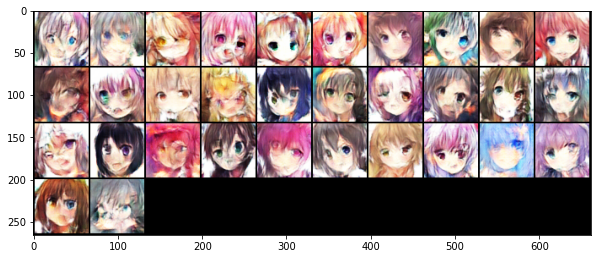

In [ ]:
#Generate 1000 images and make a grid to save them
n_output = 1000
z_sample = Variable(torch.randn(n_output, z_dim)).cuda()
imgs_sample = (G(z_sample).data + 1) / 2
log_dir = os.path.join(workspace_dir, 'logs')
filename = os.path.join(log_dir, 'result.jpg')
torchvision.utils.save_image(imgs_sample, filename, nrow = 10)

#Show 32 of the images
grid_img = torchvision.utils.make_grid(imgs_sample[:32].cpu(), nrow = 10)
plt.figure(figsize = (10, 10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

# Compress the generated images using tar

In [ ]:
#Save the generated images
os.makedirs('output', exist_ok = True)
for i in range(1000):
  torchvision.utils.save_image(imgs_sample[i], f'output/{i + 1}.jpg')

%cd output
!tar -zcf ../images.tgz * .jpg
%cd ..

/content/output
tar: .jpg: Cannot stat: No such file or directory
tar: Exiting with failure status due to previous errors
/content
